In [29]:
import sys
sys.path.insert(0, '..')
import mxnet as mx
%matplotlib inline
from matplotlib.pylab import imshow
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from mxnet.gluon import data as gdata
import sys
import time
from mxnet import gluon, init, autograd
from mxnet.gluon import loss as gloss, nn
from gluoncv.utils import viz

In [30]:
# train_dataset = mx.gluon.data.vision.ImageFolderDataset("/Users/dinesh/python-test/flower_photos/train", transform=lambda data, label: (data.astype(np.float32)/255, label))
# test_dataset = mx.gluon.data.vision.ImageFolderDataset("/Users/dinesh/python-test/flower_photos/test", transform=lambda data, label: (data.astype(np.float32)/255, label))
train_dataset = mx.gluon.data.vision.ImageFolderDataset("/Users/dinesh/python-test/flower_photos/train", transform=lambda data, label: (data.astype(np.float32)/255, label))
test_dataset = mx.gluon.data.vision.ImageFolderDataset("/Users/dinesh/python-test/flower_photos/test", transform=lambda data, label: (data.astype(np.float32)/255, label))
# train_dataset = mx.gluon.data.vision.ImageFolderDataset("/Users/dinesh/python-test/flower_photos/train", transform=lambda data, label: (data.astype(np.float32)/255, label))
# test_dataset = mx.gluon.data.vision.ImageFolderDataset("/Users/dinesh/python-test/flower_photos/test", transform=lambda data, label: (data.astype(np.float32)/255, label))

3309
361


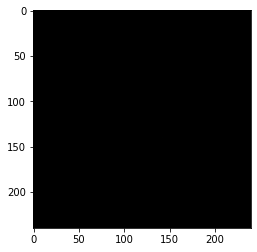

In [31]:
print(len(train_dataset))
sample_idx = 1000
sample = train_dataset[sample_idx]
viz.plot_image(sample[0])
print(len(test_dataset))

In [32]:
batch_size = 256
transformer = gdata.vision.transforms.Compose([gdata.vision.transforms.Resize(300), gdata.vision.transforms.CenterCrop(256),gdata.vision.transforms.ToTensor()])
if sys.platform.startswith('win'):
   # 0 means no additional processes are needed to speed up the reading of
   # data
   num_workers = 0
else:
   num_workers = 4

train_iter = gdata.DataLoader( train_dataset.transform_first(transformer),
   batch_size, shuffle=True,
   num_workers=num_workers)
test_iter = gdata.DataLoader( test_dataset.transform_first(transformer),
   batch_size, shuffle=False,
   num_workers=num_workers)

In [33]:
#Initialize the Model
def init(net, optimizer='sgd', learning_rate=0.1, weight_decay=1e-6, ctx=mx.cpu()):
   net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
   trainer = gluon.Trainer(net.collect_params(),
                           optimizer,
                           {'learning_rate': learning_rate, 'wd': weight_decay})
   return trainer

In [34]:
# Computing Accuracy
def accuracy(data_iterator, net,ctx=mx.cpu()):
   acc = mx.metric.Accuracy()
   for (data, label) in data_iterator:
       data = data.as_in_context(ctx)
       label = label.as_in_context(ctx)
       output = net(data)
       predictions = mx.nd.argmax(output, axis=1)
       acc.update(preds=predictions, labels=label)
   return acc.get()[1]

In [35]:
#Training the Model
def train(net, trainer, train_data, validation_data, epochs, ctx=mx.cpu()):
   training_accuracies = []
   validation_accuracies = []
   softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
   for e in range(epochs):
       tic = time.time()
       for (data, label) in train_data:
           data  = data.as_in_context(ctx)
           label = label.as_in_context(ctx)
           with autograd.record():
               output = net(data)
               loss = softmax_cross_entropy(output, label)
               loss.backward()
           trainer.step(data.shape[0])
       toc = time.time()
       train_accuracy = accuracy(train_data, net)
       training_accuracies.append(train_accuracy)
       validation_accuracy = accuracy(validation_data, net)
       validation_accuracies.append(validation_accuracy)
       print("Epoch#%d Time=%.2f Training=%.4f Validation=%.4f Diff=%.4f"
             % (e, toc-tic, train_accuracy, validation_accuracy, train_accuracy-validation_accuracy))
   return training_accuracies, validation_accuracies

In [36]:
#Plotting
def plot_accuracies(training_accuracies, validation_accuracies):
   epochs = len(training_accuracies)
   plt.clf()
   fig, ax = plt.subplots()
   plt.xlabel('Epochs')
   plt.ylabel('Accuracy')
   train_plot, = ax.plot(range(epochs), training_accuracies, label="Training accuracy")
   validation_plot, = ax.plot(range(epochs), validation_accuracies, label="Validation accuracy")
   plt.legend(handles=[train_plot,validation_plot])
   plt.xticks(np.arange(0, epochs, 5))
   ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
   plt.show()

In [ ]:
net = nn.Sequential()
net.add(nn.Dense(10))
trainer = init(net)
print(net)
training_accuracies, validation_accuracies = train(net, trainer, train_iter, test_iter, 50)
plot_accuracies(training_accuracies, validation_accuracies)

Sequential(
  (0): Dense(None -> 10, linear)
)
